In [16]:
# 환경 세팅
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [17]:
from google.colab import drive
drive.mount('/content/drive')

# 'MyDrive' 경로를 추가해야 해!
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/credit_preprocessing_total.parquet', engine='pyarrow')
# 잘 불러와졌는지 확인
print("데이터 로드 완료!")
df.info()

df_test = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/test_preprocessing_total.parquet', engine='pyarrow')
# 잘 불러와졌는지 확인
print("데이터 로드 완료!")
df_test.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 로드 완료!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Columns: 858 entries, 기준년월 to 혜택수혜율_B0M
dtypes: float32(57), float64(4), int16(148), int32(147), int8(452), object(50)
memory usage: 4.5+ GB
데이터 로드 완료!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 857 entries, 기준년월 to 혜택수혜율_B0M
dtypes: float32(57), float64(4), int16(153), int32(139), int8(455), object(49)
memory usage: 1.1+ GB


In [18]:
import sys
from google.colab import drive

drive.mount('/content/drive')

pkgs_path = '/content/drive/MyDrive/colab_pip'

# 경로를 리스트의 가장 앞(0번 인덱스)에 추가해서 우선순위를 높임
if pkgs_path not in sys.path:
    sys.path.insert(0, pkgs_path)

try:
    import catboost
    print(f"성공! 버전: {catboost.__version__}")
except ImportError:
    print("여전히 못 찾고 있어. 폴더 구조를 다시 확인해봐야 할 것 같아.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
성공! 버전: 1.2.8


In [19]:
# 경로 설정
save_path = '/content/drive/MyDrive/Colab Notebooks/'

# 불러오기 코드
loaded_mapping = {}
target_lists = ['Missing>50%', 'Constant', 'Imbalanced', 'FinalDrop']

for list_name in target_lists:
    file_name = f"{list_name}.txt"
    full_path = os.path.join(save_path, file_name)

    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            loaded_mapping[list_name] = [line.strip() for line in f.readlines()]
        print(f"📂 드라이브에서 불러오기 성공: {file_name}")
    except FileNotFoundError:
        print(f"❌ 파일을 찾을 수 없어: {full_path}")

# 변수 재할당
over_50_missing_cols = loaded_mapping.get('Missing>50%', [])
constant_cols = loaded_mapping.get('Constant', [])
imbalanced_col_names = loaded_mapping.get('Imbalanced', [])
final_drop_list = loaded_mapping.get('FinalDrop', [])


📂 드라이브에서 불러오기 성공: Missing>50%.txt
📂 드라이브에서 불러오기 성공: Constant.txt
📂 드라이브에서 불러오기 성공: Imbalanced.txt
📂 드라이브에서 불러오기 성공: FinalDrop.txt


In [20]:
# 1. 파일 경로 설정 (주신 코드를 그대로 활용했어!)
full_path = os.path.join(save_path, 'zero_importance_features 5000.txt')

# 2. 파일 읽어서 zero_importance_features 리스트에 할당하기
try:
    with open(full_path, 'r', encoding='utf-8') as f:
        # strip()을 사용해 양쪽 공백과 줄바꿈을 제거하고, 빈 줄은 제외하는 방식이야
        zero_importance_features = [line.strip() for line in f if line.strip()]

    print(f"성공적으로 {len(zero_importance_features)}개의 피처를 불러왔어! 😊")

except FileNotFoundError:
    print("어라, 파일 경로가 맞는지 확인해봐야 할 것 같아! 파일을 찾을 수 없대. 😅")

# set으로 변환해서 교집합 찾기
suspect = list(set(over_50_missing_cols) | set(imbalanced_col_names)) #여기를 변경

print(f"공통 항목 개수: {len(suspect)}개")
print(f"의심 항목 리스트: {suspect}")

성공적으로 165개의 피처를 불러왔어! 😊
공통 항목 개수: 369개
의심 항목 리스트: ['RP건수_건강_B0M', '증감_RP건수_보험_전월', 'IB문의건수_선결제_B0M', 'IB문의건수_SMS_R6M', 'RV_평균잔액_R6M', '증감율_이용금액_카드론_전월', '할부건수_12M_R12M', '이용건수_C페이_B0M', '불만제기건수_R12M', '잔액_할부_해외_B0M', '컨택건수_리볼빙_인터넷_R6M', '할부금액_유이자_12M_R12M', '잔액_리볼빙일시불이월_B0M', '한도심사요청건수', '납부_유선방송이용금액', '이용금액_R3M_신용_가족', '연체원금_최근', 'IB문의건수_부대서비스_B0M', 'IB문의건수_사용승인내역_B0M', '시장연체상환여부_R6M', 'RV신청일자', '증감율_이용건수_카드론_전월', '납부_건강연금이용금액', '건수_할부전환_R6M', '컨택건수_부대서비스_TM_B0M', '이용후경과월_부분무이자', '연체잔액_일시불_B0M', '증감_RP건수_가스_전월', '포인트_포인트_월적립_B0M', '유효카드수_체크_가족', '연체일자_B0M', '컨택건수_리볼빙_LMS_R6M', '할인금액_기본연회비_B0M', '이용금액_카드론_R3M', '최종카드론_거치개월수', '이용금액_부분무이자_B0M', '컨택건수_포인트소진_TM_R6M', '이용개월수_카드론_R6M', '컨택건수_이용유도_당사앱_B0M', 'IB상담건수_금감원_B0M', '컨택건수_카드론_인터넷_R6M', 'IB문의건수_카드발급_R6M', '컨택건수_카드론_청구서_B0M', '_3순위여유업종', '_1순위여유업종', '상품관련면제카드수_B0M', 'RP건수_전기_B0M', '할부건수_부분_12M_R12M', '인입불만월수_IB_R6M', '청구금액_제휴연회비_B0M', '이용후경과월_카드론', '연체잔액_할부_B0M', 'IB문의건수_SMS_B0M', '승인거절건수_한도초과_B0M', '이용개월수_B페이_R6M', '이용건수_선결제_B0M', '이

In [21]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 0. 클래스 별 가중치 계산 (데이터가 적을수록 높은 가중치)


# 1. 타겟 매핑 및 컬럼 제거
target_map = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
df['Segment'] = df['Segment'].map(target_map)
df = df.dropna(subset=['Segment'])

drop_cols = ['ID', '기준년월'] + suspect #여기를 변경
X = df.drop(columns=drop_cols + ['Segment'])
y = df['Segment']
X_test = df_test.drop(columns=drop_cols)

# --- [수정 포인트 1] fillna 제거 및 타입 강제 변환 ---
# 800개 컬럼에 fillna를 하는 대신, CatBoost가 인식할 수 있게 문자열 타입으로만 바꿉니다.
# 'None'으로 채우는 것보다 astype(str)이 더 효율적이며, 결측치는 자동으로 'nan' 문자열이 됩니다.
cat_features = X.columns[X.dtypes == 'object'].tolist()
for col in cat_features:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# 2. Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. CatBoost Pool 생성
# 이미 문자열 처리가 끝났으므로 Pool 생성 속도가 훨씬 빨라집니다.
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
test_pool = Pool(data=X_test, cat_features=cat_features)

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = dict(zip(classes, weights))

# 4. [수정 포인트 2] GPU 학습 가속 파라미터 적용
model = CatBoostClassifier(
    iterations=5000,
    early_stopping_rounds=200,
    task_type='GPU',
    devices='0',
    learning_rate=0.05,
    depth=6,
    eval_metric='MultiClass',
    class_weights=class_weights_dict, # 가중치 적용
    random_seed=42,
    verbose=100,
    # --- 속도 향상을 위한 핵심 옵션 ---
    bootstrap_type='Poisson',      # GPU에서 가장 빠른 샘플링 방식
    max_ctr_complexity=1,         # 범주형 변수 결합 연산을 단순화 (800개 컬럼일 때 필수)
    gpu_ram_part=0.8,             # GPU 메모리 점유율 확대 (학습 속도 향상)
    border_count=32               # 수치형 변수의 분기점 개수 제한 (속도 대폭 상승, 성능 타격 적음)
)

model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200)

0:	learn: 1.5134020	test: 1.5111615	best: 1.5111615 (0)	total: 116ms	remaining: 19m 20s
100:	learn: 0.4431486	test: 0.4649737	best: 0.4649737 (100)	total: 9.52s	remaining: 15m 33s
200:	learn: 0.3684573	test: 0.3954141	best: 0.3954141 (200)	total: 19.6s	remaining: 15m 54s
300:	learn: 0.3355555	test: 0.3640538	best: 0.3640538 (300)	total: 29.6s	remaining: 15m 53s
400:	learn: 0.3153897	test: 0.3468042	best: 0.3468042 (400)	total: 39.6s	remaining: 15m 46s
500:	learn: 0.3006765	test: 0.3337885	best: 0.3337885 (500)	total: 49s	remaining: 15m 29s
600:	learn: 0.2902841	test: 0.3239980	best: 0.3239980 (600)	total: 58.3s	remaining: 15m 11s
700:	learn: 0.2816965	test: 0.3155672	best: 0.3155672 (700)	total: 1m 7s	remaining: 14m 55s
800:	learn: 0.2742858	test: 0.3082220	best: 0.3082220 (800)	total: 1m 16s	remaining: 14m 41s
900:	learn: 0.2680898	test: 0.3028516	best: 0.3028516 (900)	total: 1m 26s	remaining: 14m 28s
1000:	learn: 0.2628593	test: 0.2981007	best: 0.2981007 (1000)	total: 1m 35s	remainin

<Figure size 1000x800 with 0 Axes>

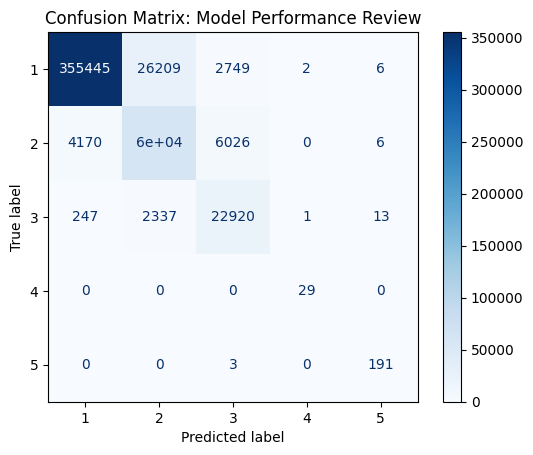

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. 모델에게 검증 데이터(X_val)를 주고 예측해보라고 시키기
y_pred = model.predict(X_val)

# 2. 실제 정답(y_val)과 모델의 예측(y_pred)을 비교해서 행렬 만들기
cm = confusion_matrix(y_val, y_pred)

# 3. 시각화할 때 라벨 달아주기
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Model Performance Review')
plt.show()

In [23]:
# 5. 예측 및 타겟 복원 (A, B, C, D, E)
inv_target_map = {5: 'A', 4: 'B', 3: 'C', 2: 'D', 1: 'E'}

df_test['pred_label'] = model.predict(test_pool)
df_test['pred_label'] = df_test['pred_label'].map(inv_target_map)

# 6. 제출 파일 생성
submission = df_test.groupby("ID")["pred_label"] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

submission.columns = ["ID", "Segment"]
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/submission.csv', index=False)

# 7. 특성 중요도가 0인 컬럼 저장
feature_importances = model.get_feature_importance()
zero_importance_features = [X.columns[i] for i, score in enumerate(feature_importances) if score == 0]

with open('/content/drive/MyDrive/Colab Notebooks/zero_importance_features.txt', 'w') as f:
    for feature in zero_importance_features:
        f.write(f"{feature}\n")

print(f"학습 완료! 중요도가 0인 컬럼 {len(zero_importance_features)}개를 저장했습니다.")

학습 완료! 중요도가 0인 컬럼 1개를 저장했습니다.
